In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import random 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

random.seed(0)

In [ ]:
# Random function
def g(x):
    return np.sin(.3*np.pi * x)

# Gaussian kernel
def kernel(u, xi, h):
    return (1 / np.sqrt(2 * np.pi)) * np.exp((-1/2) * ((u - xi)**2) / h**2)

def truncated_power_basis(x, knots):
    x = x.reshape(-1, 1)
    basis_functions = [x, x**2, x**3, np.maximum(x - knots[0], 0)**3, np.maximum(x - knots[1], 0)**3]
    return np.column_stack(basis_functions)

def gibbs_sampler_OLS(X, beta, y,B0, beta0, neu0, delta0, sigma2, num_iterations):
    n, m = X.shape
    beta_samples = np.zeros((num_iterations, m))
    sigma2_samples = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        var_B = np.linalg.inv(np.dot(X.T, X) / sigma2 + B0**(-1))
        i_b = (B0**(-1))*(beta0) + np.dot(X.T, y) / sigma2
        mean_b = np.dot(var_B, i_b)
        mean_b= np.ravel(mean_b)
        beta_samples[i, :] = np.random.multivariate_normal(mean_b, var_B)
        alpha1 = (neu0+n)/2
        beta1 = delta0 + np.dot((y-np.dot(X,beta).reshape(250,1)).T,
        (y-np.dot(X,beta).reshape(250,1))) / 2
        sigma2_samples[i] = 1 / np.random.gamma(alpha1, 1 / beta1)

    return beta_samples, sigma2_samples
  
def gibbs_sampler(Q,g, y,g0, g0til, neu0,s0,delta0, sigma2,tau2, num_iterations):
  n, m = Q.shape
  g_samples = np.zeros((num_iterations, m))
  tau2_samples = np.zeros(num_iterations)
  sigma2_samples = np.zeros(num_iterations)
  for i in range(num_iterations):
    # Sample g given tau2, sigma2, and y
    V_g = np.linalg.inv(np.dot(Q.T, Q) / sigma2 + K/ tau2)
    i_g = np.dot((K/ tau2),g0) + np.dot(Q.T, y) / sigma2
    m_g = np.dot(V_g, i_g)
    m_g = np.ravel(m_g)
    g_samples[i, :] = np.random.multivariate_normal(m_g, V_g)
    # Sample sigma2 given g
    alpha1 = (neu0+n)/2
    beta1 = delta0 + np.dot((y-np.dot(Q,g)).T, (y-np.dot(Q,g))) / 2
    sigma2_samples[i] = 1 / np.random.gamma(alpha1, 1 / beta1)
    # Sample tau2 given g
    alpha2 = (s0+n)/2
    beta2 = d0 + np.dot(np.dot((g - g0til).T,K), (g - g0til)) / 2
    tau2_samples[i] = 1 / np.random.gamma(alpha2, 1 / beta2)
    
  return g_samples, tau2_samples, sigma2_samples

1. Estimate g by the Nadaraya-Watson estimator. Plot your estimate and the true function on the same plot. How does the bandwidth parameter affect your estimate? Does your estimate exhibit boundary bias?

In [3]:
'''Creating up our Data'''
'''Pick v on an equispaced grid of 51 points over the support of your function, and generate 5 observations yi at each grid point using the model:
yi = g(xi) +ei , ei ~ iid N(0,σ^2) , i = 1, ..., n '''

n = 250 #sample size
sigma = 2 #the standard deviation (spread) of the normal distribution
mu = 1 #the mean of the normal distribution
pool_size = 1000 # the size of the pool of random numbers initially generated

# Generate 1000 values and get the number of unique values
x_pool = np.around(np.random.normal(mu, sigma, pool_size), 4)
unique_values = np.unique(x_pool)

#make sure that there are at least 51 unique values, if there are less than 51 unique values, keep regenerating. 
while len(unique_values) < 51: 
    x_pool = np.around(np.random.normal(mu, sigma, pool_size), 4)
    unique_values = np.unique(x_pool)

selected_unique_values = np.random.choice(unique_values, 50, replace=False) # randomly select 50 unique values from our values
new_x = np.random.choice(selected_unique_values, n, replace=True) # Here, a new sample new_x of size n = 250 is created by randomly choosing from the 50 selected unique values. 
new_x = new_x.reshape(-1, 1) # Reshape the 1D array into a 2D array with one column and 250 rows 
v = np.unique(new_x).reshape(50,1) # this is the array of unique values
x=new_x # Assign our new_x to x 

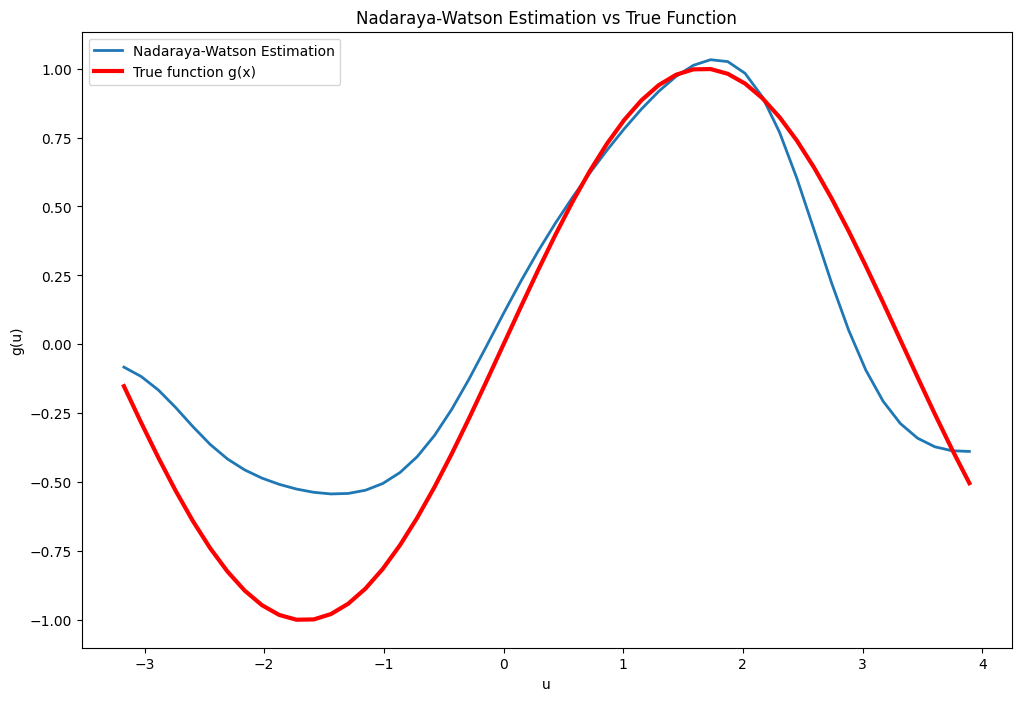

The ideal bandwidth is: 0.6200863030074715
What would happen if we change the Bandwidth? 


In [4]:
''' Calculating the kernel density estimate (KDE) bandwidth, generating a set of points for evaluation, adding noise to a function g(x), and initializing some arrays for further computation.'''
h = 1.06*np.sqrt(np.var(x))*n**(-1/5) # Silverman's rule of thumb formula for estimating the bandwidth h in kernel density estimation (KDE).
u = np.linspace(min(x), max(x), 50).reshape(-1, 1) #This generates 50 equally spaced points between the minimum and maximum values of x. 
m = u.shape[0]
y = np.array([g(xi) + np.random.normal(0, sigma) for xi in x]) #This generates the dependent variable y by evaluating some function g(x) for each xi in x and adding Gaussian noise with mean 0 and standard deviation sigma.
f = np.zeros((m, 1))
g_val = np.zeros((m, 1))

#Kernel Density Estimation (KDE) for f[i]: This estimates the probability density function of the data x at each evaluation point u[i].
for i in range(m):
    f[i] = np.sum(kernel(u[i], x, h)) / n * h

# This loop implements the Nadaraya-Watson kernel regression estimator to estimate the conditional expectation 𝐸[𝑦∣𝑥] at each point u[j].
# The Nadaraya-Watson kernel regression estimate for \( g(u) \) is given by: g(u) = \frac{\sum_{i=1}^{n} K(u, x_i, h) \cdot y_i}{\sum_{i=1}^{n} K(u, x_i, h)}
for j in range(m):
    num = np.sum(kernel(u[j], x, h) * y) / n * h
    den = np.sum(kernel(u[j], x, h)) / n * h
    g_val[j] = num / den

plt.figure(figsize=(12, 8))
plt.plot(u, g_val, label='Nadaraya-Watson Estimation', linewidth=2)
plt.plot(u, g(u), label='True function g(x)', color='red', linewidth = 3)
plt.xlabel('u')
plt.ylabel('g(u)')
plt.title('Nadaraya-Watson Estimation vs True Function')
plt.legend()
plt.show()

print("The ideal bandwidth is: " + str(h)) 
print("What would happen if we change the Bandwidth? ")

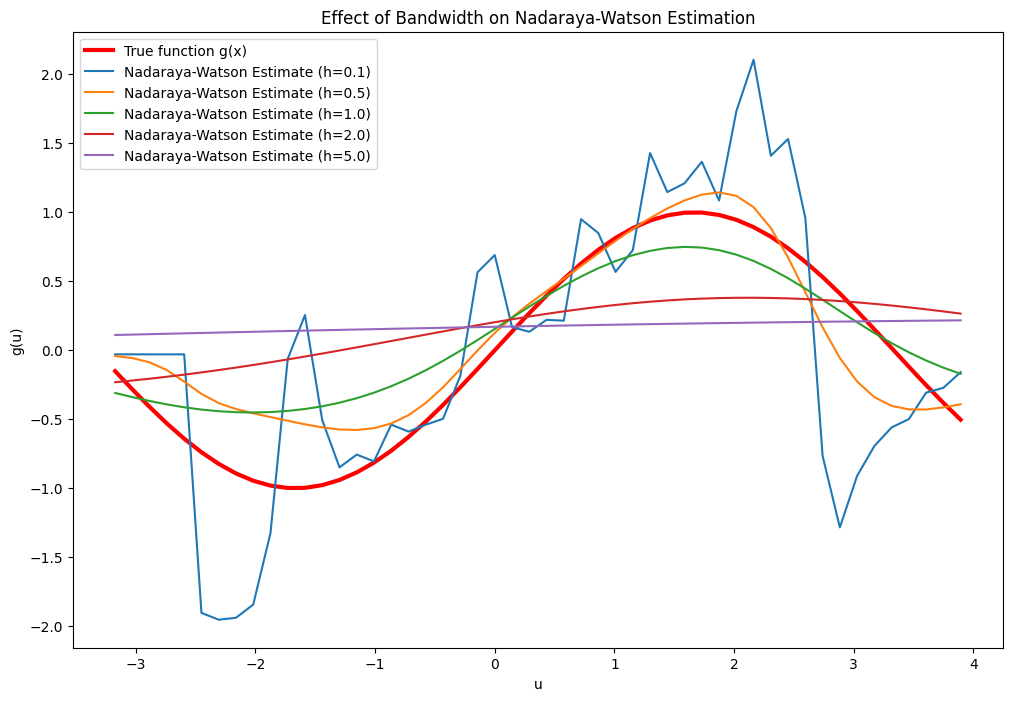

In [5]:
# Bandwidth values to test
bandwidths = [0.1, 0.5, 1.0, 2.0, 5.0]

plt.figure(figsize=(12, 8))

# Plot true function
plt.plot(u, g(u), label='True function g(x)', color='red',linewidth=3)

# Compute and plot KDE with different bandwidths
for h in bandwidths:
    #(KDE)
    f = np.zeros((m, 1))
    for i in range(m):
        f[i] = np.sum(kernel(u[i], x, h)) / n * h

    # Nadaraya-Watson kernel 
    g_val = np.zeros((m, 1))
    for j in range(m):
        num = np.sum(kernel(u[j], x, h) * y) / n * h
        den = np.sum(kernel(u[j], x, h)) / n * h
        g_val[j] = num / den

    plt.plot(u, g_val, label=f'Nadaraya-Watson Estimate (h={h})')

plt.xlabel('u')
plt.ylabel('g(u)')
plt.title('Effect of Bandwidth on Nadaraya-Watson Estimation')
plt.legend()
plt.show()


2. Split the support of the function into 3 equal parts by choosing knots κ1 and κ2 and create the truncated power function basis 1, x, x2, x3, (x − κ1)3+, (x − κ2)3+.

Estimate g as X ˆβ by (i) OLS and (ii) Gibbs sampling with appropriately chosen priors (state those explicitly). Note thatnthe former is possible because there are repeating values in X and the function is restricted to be a cubic spline (flexible, yet not fully general). Plot your estimated and true function and comment on your results.

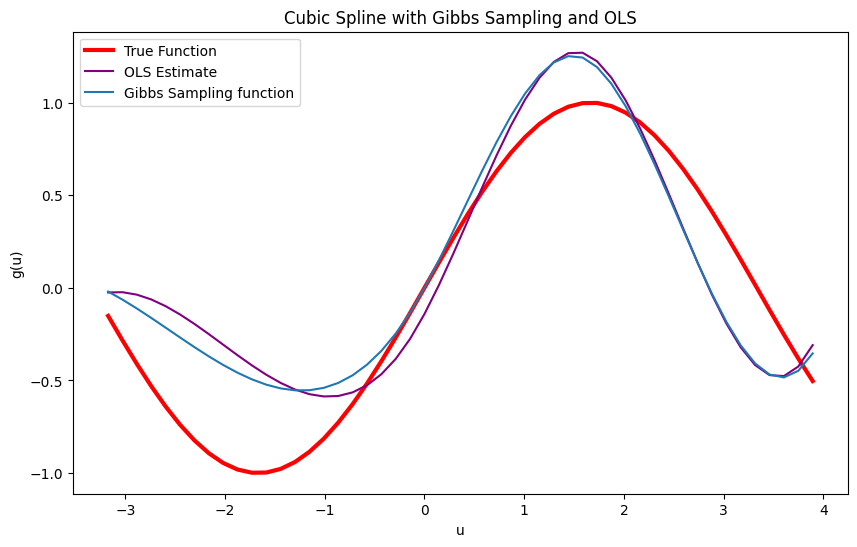

In [6]:
k1, k2 = np.percentile(x, [33.33, 66.67])
X = truncated_power_basis(x, [k1, k2])
ols_model = sm.OLS(y, sm.add_constant(X)).fit()
ols_estimates = ols_model.predict(sm.add_constant(truncated_power_basis(u, [k1,
k2]))).reshape(50,1)

B0 = 4
beta0 = 2
neu0=2
delta0= 2
sigma2 = sigma**2
num_iterations = 5000
beta= np.array([1,2,3,4,5])

beta_samples, sigma2_samples = gibbs_sampler_OLS(X, beta, y, B0, beta0, neu0, delta0,
sigma2, num_iterations)
U = truncated_power_basis(u, [k1, k2])
mean_predictions = np.dot(U, beta_samples.T).mean(axis=1).reshape(50, 1)

plt.figure(figsize=(10, 6))
plt.plot(u, g(u), label='True Function', color='red',linewidth=3)
plt.plot(u, ols_estimates, label='OLS Estimate', color='purple')
plt.plot(u, mean_predictions, label='Gibbs Sampling function')
plt.xlabel('u')
plt.ylabel('g(u)')
plt.title('Cubic Spline with Gibbs Sampling and OLS')
plt.legend()
plt.show()

3. Estimate g by the Gibbs sampler:

Collect the unique and ordered values of {xi} in vector v = (v1, ..., vm)' and let g = (g1, ..., gm)' = (g(v1), ..., g(vm))'. 
REwrite model as linear regression y = Qg + e using an incidence matix Q. 
consider the simple case when the elements in v are equally spaced and you place a second order random walk prior on the element of g. i.e. 
gt = gt-1 - gt-2 + neut, neut ~ iid N(0, tau^2), t= 3, ..., m 

(g1, g2)' = N((g10, g20)', tau^2((G110, G120), (G210, G220)))

f_N(g|tau^2) ~ N (g0, T^2*K^-1)
f_IG(tau^2| s0/2, d0/2) ~ IG ((v0 + neu) / 2 , (delta0 + (y-Qf)'(y-Qf))/2))
f_IG(sigma^2| v0/2, delta0/2) ~ IG ((s0 + m) / 2 , (d0 + (g - g~)'(g-g~))/2))

Plot your estimated and true function and comment on your results. Try several prior settings and comment on how your priors affect your estimated function.

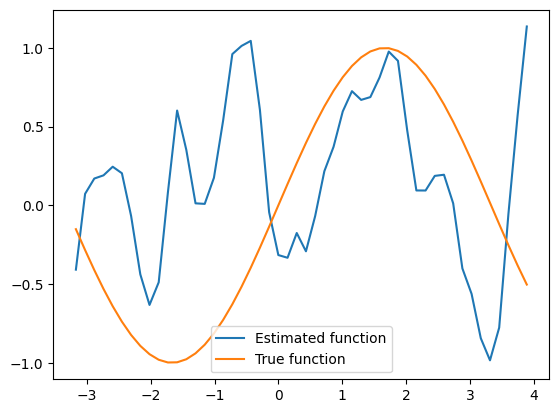

In [7]:
g10 = 0.5
g20 = 0.1
G110 = 0
G120 = 2
G210 = 2
G220 = 1

g0til = np.zeros((m, 1))
g0til[:2, :] = g10
g0til[1, :] = g20

H = np.zeros((m, m))
for i in range(m):
    if i < 2:
        H[i, i] = 1
    else:
        H[i, i - 2] = 1
        H[i, i - 1] = -2
        H[i, i] = 1

g0 = np.linalg.inv(H) @ g0til
Q = np.zeros((n, m))

for i in range(n):
    col_index = (i // 5) % n
    Q[i, col_index] = 1

f = np.array([g(xi) for xi in x])
n_iterations = 5000
tau2 = 0.4
d0 = 2
neu0 = 2
delta0 = 4
s0 = 2

VarE = np.zeros((m, m))

for i in range(m):
    if i == 0:
        VarE[0, 0] = G110
        VarE[0, 1] = G120
    elif i == 1:
        VarE[1, 0] = G210
        VarE[1, 1] = G220
    else:
        VarE[i, i] = 1
        
K = H.T @ np.linalg.inv(VarE) @ H
gg = np.array([g(xi) for xi in v])
num_iterations = 5000
g_samples, tau2_samples, sigma2_samples = gibbs_sampler(Q,gg, y,g0, g0til,
neu0,s0,delta0, sigma2,tau2, num_iterations)
g_posterior_mean = np.mean(g_samples, axis=0)
plt.plot(u, g_posterior_mean, label='Estimated function')
plt.plot(u, g(u), label='True function')
plt.legend()
plt.show()


Try several prior settings and comment on how your priors affect
your estimated function.
Low values of Tau make it smoother.
Changing something like delta to a smaller number makes it
flatter.
Ensuring correct priors is key to getting a good estimate